Соревнование https://inclass.kaggle.com/c/beeline-credit-scoring-competition-3

Признаки клиентов банка:
- Age - возраст (вещественный)
- Income - месячный доход (вещественный)
- BalanceToCreditLimit - отношение баланса на кредитной карте к лимиту по кредиту (вещественный)
- DIR - Debt-to-income Ratio (вещественный)
- NumLoans - число заемов и кредитных линий
- NumRealEstateLoans - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- NumDependents - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- Num30-59Delinquencies - число просрочек выплат по кредиту от 30 до 59 дней (натуральное число)
- Num60-89Delinquencies - число просрочек выплат по кредиту от 60 до 89 дней (натуральное число)
- Delinquent90 - были ли просрочки выплат по кредиту более 90 дней (бинарный) - имеется только в обучающей выборке

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pydot
import sklearn
from graphviz import Source

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

def quality_report(prediction, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual)
    ))
    

def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

In [4]:
import seaborn as sns

## Загружаем данные

In [100]:
train_df = pd.read_csv('datasets/credit_scoring_train.csv', index_col='client_id')
test_df = pd.read_csv('datasets/credit_scoring_test.csv', index_col='client_id')

In [54]:
train_df.shape

(75000, 10)

In [55]:
train_df.head()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
client_id,,,,,,,,,,
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0
2,2206.731199,55.5,21,1,NaN,1,0,NaN,0.348227,0
3,886.132793,55.3,3,0,0.0,0,0,NaN,0.971930,0
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0


In [8]:
test_df.shape

(75000, 9)

## Посчитаем число пропусков в каждом признаке

In [9]:
train_df.isnull().sum()/train_df.shape[0]

DIR                      0.000000
Age                      0.000000
NumLoans                 0.000000
NumRealEstateLoans       0.000000
NumDependents            0.025547
Num30-59Delinquencies    0.000000
Num60-89Delinquencies    0.000000
Income                   0.197960
BalanceToCreditLimit     0.000000
Delinquent90             0.000000
dtype: float64

In [10]:
test_df.isnull().sum()

DIR                          0
Age                          0
NumLoans                     0
NumRealEstateLoans           0
NumDependents             2008
Num30-59Delinquencies        0
Num60-89Delinquencies        0
Income                   14884
BalanceToCreditLimit         0
dtype: int64

In [101]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df.drop(['Delinquent90'], axis=1),
    train_df['Delinquent90'],
    test_size=0.20,
    random_state=42,
    stratify=train_df['Delinquent90']
)

In [12]:
y_train.value_counts(normalize=True)

0    0.933167
1    0.066833
Name: Delinquent90, dtype: float64

In [13]:
y_test.value_counts(normalize=True)

0    0.933133
1    0.066867
Name: Delinquent90, dtype: float64

In [14]:
X_train['NumDependents'].fillna(X_train['NumDependents'].median(), inplace=True)
X_train['Income'].fillna(X_train['Income'].median(), inplace=True)

X_test['NumDependents'].fillna(X_test['NumDependents'].median(), inplace=True)
X_test['Income'].fillna(X_test['Income'].median(), inplace=True)


In [15]:
test_df['NumDependents'].fillna(X_train['NumDependents'].median(), inplace=True)
test_df['Income'].fillna(X_train['Income'].median(), inplace=True)

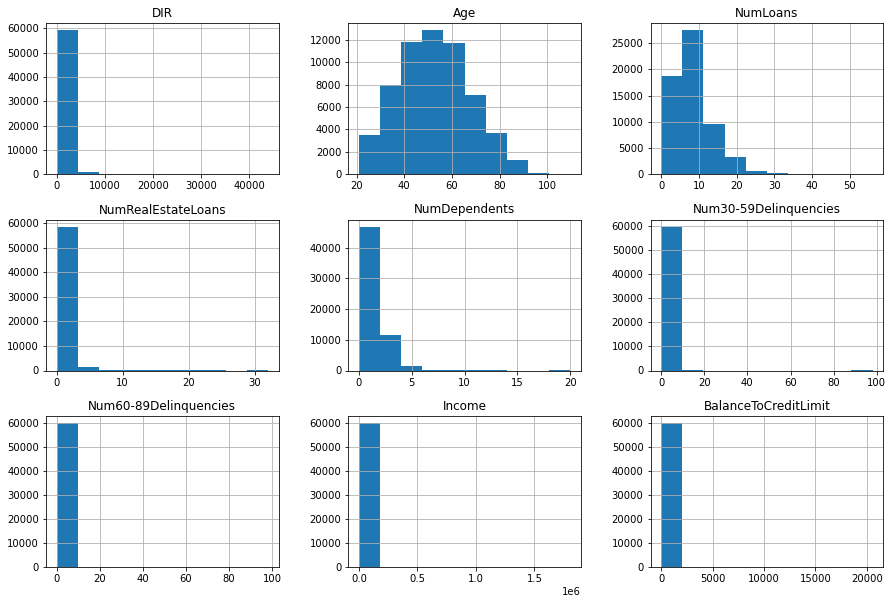

In [16]:
X_train.hist(figsize=(15, 10));

In [17]:
# sns.pairplot(X_train, hue='Delinquent90');

## Baseline

In [18]:
y_naive = np.random.choice(
    [0, 1],
    size=y_test.shape[0],
    p=y_train.value_counts(normalize=True))

In [19]:
quality_report(y_naive, y_test)

Accuracy: 0.875
Precision: 0.069
Recall: 0.069
f1_score: 0.069


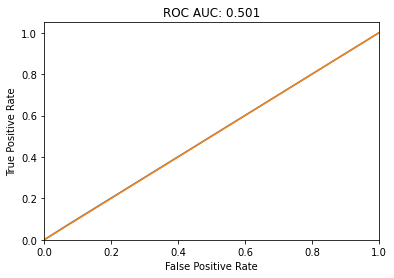

In [20]:
plot_roc_curve(y_naive, y_test)

## Дерево решений без настройки параметров

In [21]:
first_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
first_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [22]:
print('Train Quality')
quality_report(first_tree.predict(X_train), y_train)

print('\nTest Quality')
quality_report(first_tree.predict(X_test), y_test)

Train Quality
Accuracy: 0.934
Precision: 0.047
Recall: 0.607
f1_score: 0.088

Test Quality
Accuracy: 0.934
Precision: 0.050
Recall: 0.588
f1_score: 0.092


In [23]:
first_tree.predict_proba(X_test)[:, 1]

array([0.27672727, 0.27672727, 0.02004237, ..., 0.02004237, 0.02004237,
       0.02004237])

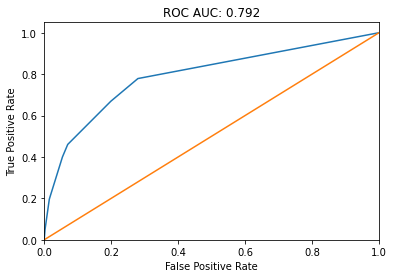

In [24]:
plot_roc_curve(first_tree.predict_proba(X_test)[:, 1], y_test)

In [25]:
first_tree.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16640895, 0.50080636, 0.        , 0.33278469])

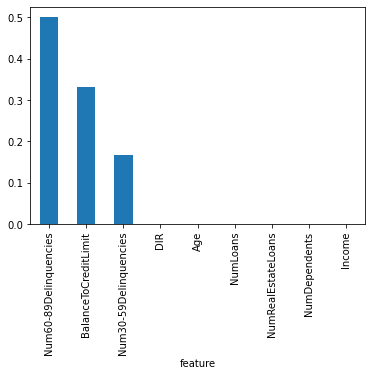

In [26]:
featureImportance = pd.DataFrame({'feature': X_train.columns,
                                 'importance': first_tree.feature_importances_})
featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(['importance'], ascending=False, inplace=True)
featureImportance['importance'].plot(kind='bar');

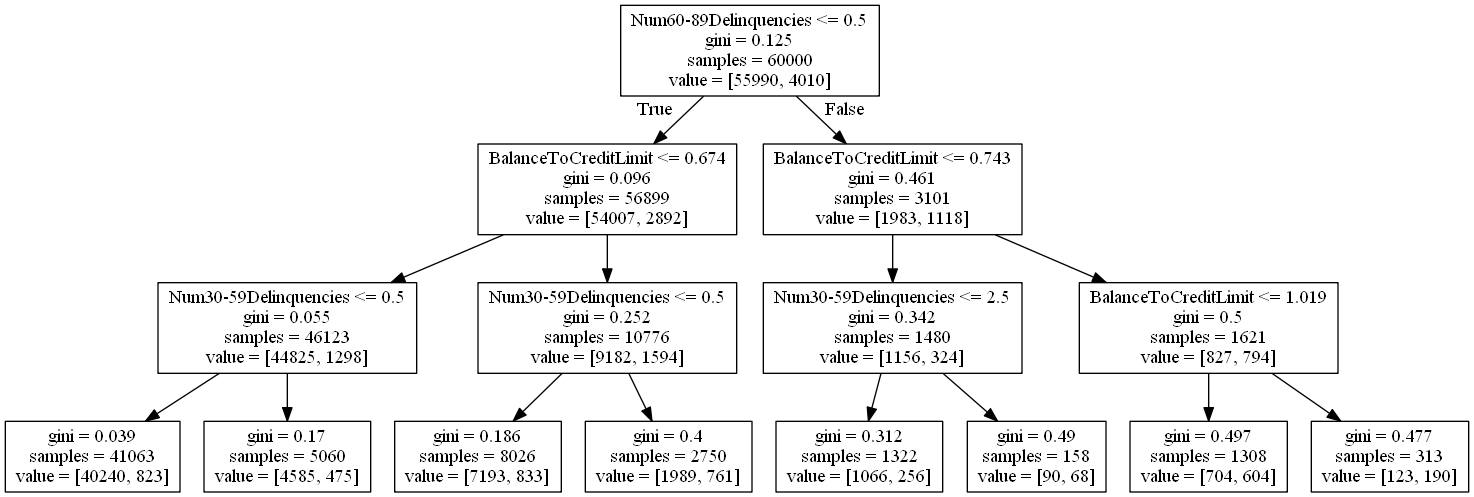

In [27]:
graph = Source(sklearn.tree.export_graphviz(first_tree, out_file=None, feature_names=X_train.columns))
png_bytes = graph.pipe(format='png')
with open('pics/dtree_pipe.png', 'wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

## Прогноз для тестовой выборки

In [28]:
first_tree_pred = first_tree.predict(test_df)

In [29]:
np.bincount(first_tree_pred)

array([74608,   392], dtype=int64)

## Запишем прогноз в файл

In [30]:
def write_ti_submission_file(predicted_labels, out_file,
                             target='Delinquent90', index_label='client_id'):
    # turn prediction into data frame and save it to csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index=np.arange(75000, 
                                               predicted_labels.shape[0] + 75000),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [31]:
first_tree_pred_probs = first_tree.predict_proba(test_df)[:, 1]

In [32]:
write_ti_submission_file(first_tree_pred_probs, 'datasets/credit_scoring_first_tree_prob.csv')

## Дерево решений с настройкой параметров с помощью GridSearch

In [39]:
tree_params = {
    'max_depth': list(range(3, 11)),
    'min_samples_leaf': list(range(3, 11)),
    'class_weight': [None, 'balanced']
}
locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                tree_params,
                                verbose=True, n_jobs=-1, cv=5,
                                scoring='roc_auc')
locally_best_tree.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='roc_auc', verbose=True)

In [35]:
locally_best_tree.best_params_, round(locally_best_tree.best_score_, 3)

({'class_weight': None, 'max_depth': 6, 'min_samples_leaf': 10}, 0.83)

In [37]:
quality_report(locally_best_tree.predict(X_test), y_test)

Accuracy: 0.933
Precision: 0.142
Recall: 0.497
f1_score: 0.220


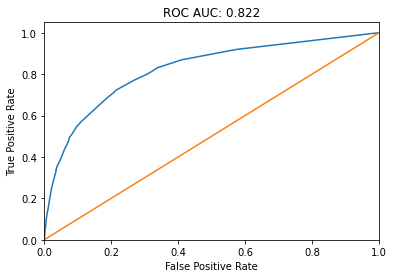

In [38]:
plot_roc_curve(locally_best_tree.predict_proba(X_test)[:, 1], y_test)

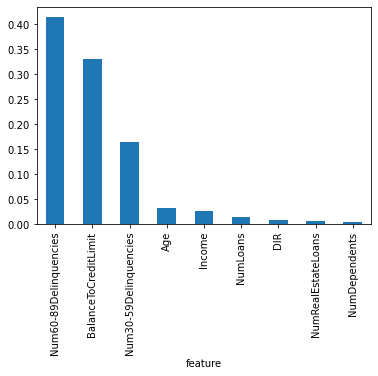

In [43]:
featureImportance = pd.DataFrame({'feature': X_train.columns,
                                  'importance': locally_best_tree.best_estimator_.feature_importances_})
featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(['importance'], ascending=False, inplace=True)
featureImportance['importance'].plot(kind='bar');

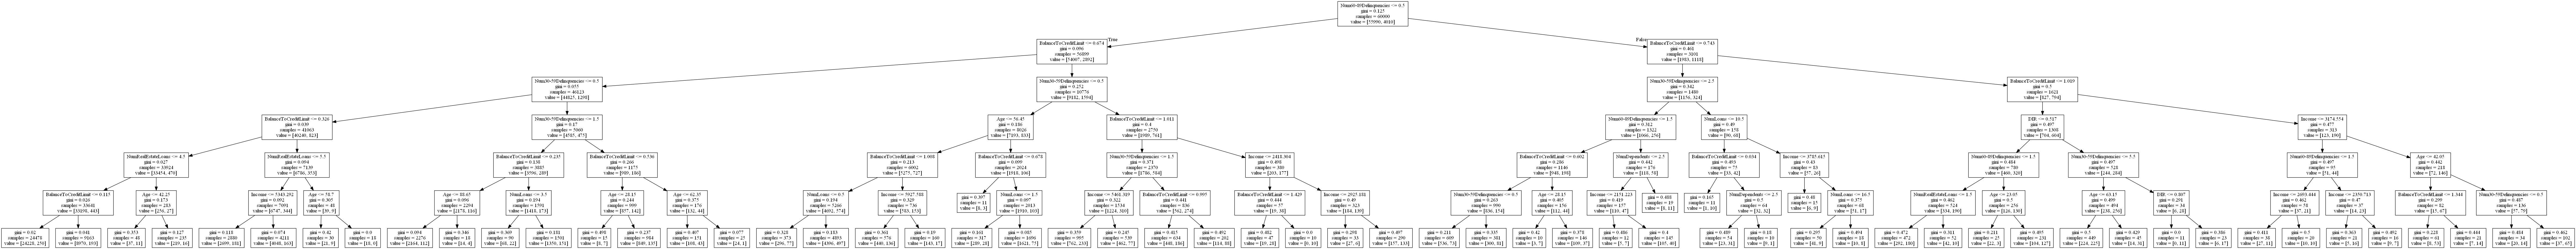

In [44]:
graph = Source(sklearn.tree.export_graphviz(
    locally_best_tree.best_estimator_, out_file=None, feature_names=X_train.columns))
png_bytes = graph.pipe(format='png')
with open('pics/big_tree.png', 'wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

<AxesSubplot:>

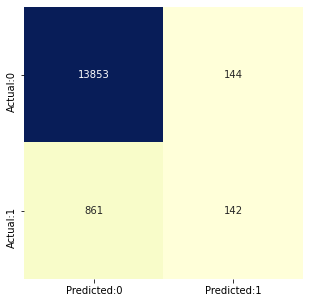

In [48]:
cm = confusion_matrix(y_test, locally_best_tree.predict(X_test)) 
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False)

# Регрессия в sklearn SVM

In [49]:
from sklearn.svm import SVR

In [50]:
SVR()

SVR()

Init signature:
SVR(
    *,
    kernel='rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    tol=0.001,
    C=1.0,
    epsilon=0.1,
    shrinking=True,
    cache_size=200,
    verbose=False,
    max_iter=-1,
)
Docstring:     
Epsilon-Support Vector Regression.

The free parameters in the model are C and epsilon.

The implementation is based on libsvm. The fit time complexity
is more than quadratic with the number of samples which makes it hard
to scale to datasets with more than a couple of 10000 samples. For large
datasets consider using :class:`~sklearn.svm.LinearSVR` or
:class:`~sklearn.linear_model.SGDRegressor` instead, possibly after a
:class:`~sklearn.kernel_approximation.Nystroem` transformer.

Read more in the :ref:`User Guide <svm_regression>`.

Parameters
----------
kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf'
     Specifies the kernel type to be used in the algorithm.
     It must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or
     a callable.
     If none is given, 'rbf' will be used. If a callable is given it is
     used to precompute the kernel matrix.

degree : int, default=3
    Degree of the polynomial kernel function ('poly').
    Ignored by all other kernels.

gamma : {'scale', 'auto'} or float, default='scale'
    Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.

    - if ``gamma='scale'`` (default) is passed then it uses
      1 / (n_features * X.var()) as value of gamma,
    - if 'auto', uses 1 / n_features.

    .. versionchanged:: 0.22
       The default value of ``gamma`` changed from 'auto' to 'scale'.

coef0 : float, default=0.0
    Independent term in kernel function.
    It is only significant in 'poly' and 'sigmoid'.

tol : float, default=1e-3
    Tolerance for stopping criterion.

C : float, default=1.0
    Regularization parameter. The strength of the regularization is
    inversely proportional to C. Must be strictly positive.
    The penalty is a squared l2 penalty.

epsilon : float, default=0.1
     Epsilon in the epsilon-SVR model. It specifies the epsilon-tube
     within which no penalty is associated in the training loss function
     with points predicted within a distance epsilon from the actual
     value.

shrinking : bool, default=True
    Whether to use the shrinking heuristic.
    See the :ref:`User Guide <shrinking_svm>`.

cache_size : float, default=200
    Specify the size of the kernel cache (in MB).

verbose : bool, default=False
    Enable verbose output. Note that this setting takes advantage of a
    per-process runtime setting in libsvm that, if enabled, may not work
    properly in a multithreaded context.

max_iter : int, default=-1
    Hard limit on iterations within solver, or -1 for no limit.

Attributes
----------
class_weight_ : ndarray of shape (n_classes,)
    Multipliers of parameter C for each class.
    Computed based on the ``class_weight`` parameter.

coef_ : ndarray of shape (1, n_features)
    Weights assigned to the features (coefficients in the primal
    problem). This is only available in the case of a linear kernel.

    `coef_` is readonly property derived from `dual_coef_` and
    `support_vectors_`.

dual_coef_ : ndarray of shape (1, n_SV)
    Coefficients of the support vector in the decision function.

fit_status_ : int
    0 if correctly fitted, 1 otherwise (will raise warning)

intercept_ : ndarray of shape (1,)
    Constants in decision function.

n_support_ : ndarray of shape (n_classes,), dtype=int32
    Number of support vectors for each class.

shape_fit_ : tuple of int of shape (n_dimensions_of_X,)
    Array dimensions of training vector ``X``.

support_ : ndarray of shape (n_SV,)
    Indices of support vectors.

support_vectors_ : ndarray of shape (n_SV, n_features)
    Support vectors.

Examples
--------
>>> from sklearn.svm import SVR
>>> from sklearn.pipeline import make_pipeline
>>> from sklearn.preprocessing import StandardScaler
>>> import numpy as np
>>> n_samples, n_features = 10, 5
>>> rng = np.random.RandomState(0)
>>> y = rng.randn(n_samples)
>>> X = rng.randn(n_samples, n_features)
>>> regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
>>> regr.fit(X, y)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

See Also
--------
NuSVR : Support Vector Machine for regression implemented using libsvm
    using a parameter to control the number of support vectors.

LinearSVR : Scalable Linear Support Vector Machine for regression
    implemented using liblinear.

References
----------
.. [1] `LIBSVM: A Library for Support Vector Machines
    <http://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf>`_

.. [2] `Platt, John (1999). "Probabilistic outputs for support vector
    machines and comparison to regularizedlikelihood methods."
    <http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.41.1639>`_
File:           c:\users\adwiz\anaconda3\lib\site-packages\sklearn\svm\_classes.py
Type:           ABCMeta
Subclasses:     

In [99]:
X_train.head()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,income
client_id,,,,,,,,,,
20002,0.664432,44.1,6,2,1.0,0,0,7542.722069,0.086407,7542.722069
25282,0.965690,74.7,13,3,0.0,0,0,5200.174283,0.622835,5200.174283
65696,610.405340,26.2,9,0,0.0,0,0,5421.537884,0.295761,5421.537884
4900,1.136009,40.1,11,2,0.0,0,0,4182.235090,0.417074,4182.235090
53270,7086.843783,51.2,12,4,0.0,0,0,5421.537884,0.361519,5421.537884


In [87]:
from sklearn.impute import SimpleImputer

In [88]:
imputer = SimpleImputer(strategy='median')

In [109]:
imputer.fit(X_train['Income'].values.reshape(-1,1))

SimpleImputer(strategy='median')

In [110]:
imputer.statistics_

array([5421.537884])

In [123]:
X_train['Income'].values.reshape(-1,1)

array([[ 7542.722069],
       [ 5200.174283],
       [ 5421.537884],
       ...,
       [ 5221.491177],
       [39701.598813],
       [ 5878.827714]])

In [112]:
imputer

SimpleImputer(strategy='median')

In [119]:
X_train['Income'] = imputer.transform(X_train['Income'].values.reshape(-1,1))
X_test['Income'] = imputer.transform(X_test['Income'].values.reshape(-1,1))

NotFittedError: This SimpleImputer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [114]:
X_train['Income']

client_id
20002     7542.722069
25282     5200.174283
65696     5421.537884
4900      4182.235090
53270     5421.537884
             ...     
31368     5040.596536
60        3018.671179
54901     5221.491177
73529    39701.598813
21437     5878.827714
Name: Income, Length: 60000, dtype: float64

In [125]:
imputer = SimpleImputer(strategy='median')
X_test['Income'] = imputer.fit_transform(X_test['Income'].values.reshape(-1,1))
X_train['Income'] = imputer.fit_transform(X_train['Income'].values.reshape[-1, 1])

TypeError: 'builtin_function_or_method' object is not subscriptable

In [116]:
from sklearn.preprocessing import StandardScaler

In [117]:
scaler = StandardScaler()

In [124]:
scaler.fit_transform(X_train['Income'].values.reshape(-1,1))

array([[ 0.073363  ],
       [-0.09404224],
       [-0.07822296],
       ...,
       [-0.09251887],
       [ 2.37152936],
       [-0.0455437 ]])

In [126]:
scaler.scale_, scaler.var_

(array([13993.27628617]), array([1.95811781e+08]))

In [128]:
scaler.transform(X_test['Income'].values.reshape(-1, 1))

array([[-0.46558968],
       [-0.20337978],
       [-0.07613339],
       ...,
       [-0.03401457],
       [-0.07822296],
       [-0.07822296]])

In [129]:
scaler.transform(X_train['Income'].values.reshape(-1, 1))

array([[ 0.073363  ],
       [-0.09404224],
       [-0.07822296],
       ...,
       [-0.09251887],
       [ 2.37152936],
       [-0.0455437 ]])